# Coarsened Exact Matching with Uplift estimator: Use Case and Examples

Coarsened exact matching (CEM) is a widely used non-parametric matching method and is often compared to PSM.
You need to be careful that CEM does not provide ATE estimation, because it discard both treatment group observations and control group observations. If no treated units are unmatched, you can estimate the average treatment effect on the treated (ATT). If any treated units are discarded, the estimand is the average treatment effect in the matched sample (ATM). The advantage of CEM is that it guarantees your data to be post-match balance, therefore is a good data-preprocess tool that can be used together with other estimator such as uplift.

In this example, we also show how to compute uplift estimator based on post-matching data, and compare their performance.

### Data

CEM in settings where we have several different types of observations:
* Covariates, which we will denote with `X`
* Treatment, which we will denote with `T`
* Responses, which we will denote with `Y`

Requirement is that `T` is a binary varible which contain only 0/1 values.

### Estimation

To construct a CEM estimator, we follow following steps:
1. We determine if X varibles you input is categorical or continuous based on X dtype: string/object are treated as categorical variables, int/float are treated as numeric type.
2. For categorical variables, each value is seen as one bin; for continuous variable, we cut 5 percentile and treat each percentile as a bin.
3. Finally we concatenate all bins together, and see if any bin contains only treated obs or only control obs. If so then we drop the bin.


In [1]:
# Set the path of current github project folder
import sys
print(sys.path)
sys.path.append('/Users/bytedance/PycharmProjects/github/CausalMatch')

# Import the most update version of causalmatch
import causalmatch as causalmatch
from causalmatch import matching, gen_test_data, gen_test_data_panel
from causalmatch.matching.match_core.utils import data_process_bc,data_process_ate
from causalmatch.matching.match_core.meta_learner import SMAPE
print('current version is: ',causalmatch.__version__)

# check which python jupyter notebook links to
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

# Import the rest of dependencies
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,roc_auc_score,f1_score
import statsmodels.api as sm
from matplotlib import pyplot
from functools import reduce

from sklearn.metrics import make_scorer,auc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/bytedance/Library/Python/3.12/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']
current version is:  0.0.1
/usr/local/bin/python3.12
3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## 1. generate synthetic data for example

In [17]:
df, rand_continuous, rand_true_param, param_te , rand_treatment, rand_error = gen_test_data(n = 10000, c_ratio=0.5)


X = ['c_1','d_1','d_3']

y = ['y']
id = 'user_id'

# treatment variable has to be a 0/1 dummy variable
# if is string, please convert to a 0/1 int input
T = 'treatment'

print('True treatment effect in data generating process is {}'.format(param_te))


True treatment effect in data generating process is 0.5


## 2. Matching
### 2.1. CEM

`match_obj.hte()` returns the treatment effect from a linear single learner model 
$y=f(X,T)+\varepsilon $, where $f(X,T)$ is a first order polynomial. For example, if $X=[X_1,X_2]$, $y=\alpha_0+\alpha_1 X_1 T+\alpha_2 X_2 T+\alpha_3 X_1 +\alpha_4 X_2+\alpha_5 T  +  \varepsilon$.
We also provide MAPE score based on linear model.


In [19]:
# ---------------         CEM          --------------- #
# STEP 1: initialize matching object
match_obj = matching(data = df, 
                     y = y,
                     T = T, 
                     X = X,
                     id = 'user_id')

# STEP 2: coarsened exact matching
match_obj.cem(n_bins = 10, # number of bins you set to divide continuous variables, user pd.qcut function to obatin
              k2k = True)  # k2k: make sure number of treatment equals number of control. if is false, you need to apply weighted least square to obtain ATE

# STEP 3: balance check after propensity score matching
res_post, res_pre = match_obj.balance_check(include_discrete=True)

# STEP 4: obtain average treatment effect 
print(match_obj.ate())

# STEP 5: obtain heterogeneous treatment effect based on single learner linear model
hte_linear = match_obj.hte()
print('Average heterogeneous treatment effect', np.mean(hte_linear))

number of matched obs (9768, 15) number of total obs  (10000, 15)
   y       ate         p_val
0  y  0.500467  1.832978e-26
Cross Validation Scores:  [0.26 0.28 0.27 0.25 0.27]
Average CV Score:  0.266
Number of CV Scores used in Average:  5
Average heterogeneous treatment effect 0.4952079535964221


### 2.2 PSM

In [20]:
# ---------------         PSM          --------------- #
# STEP 1: initialize matching object
match_obj = matching(data = df,
                     y = y,
                     T = T,
                     X = X,
                     id = id)

# STEP 2: propensity score matching
match_obj.psm(n_neighbors = 1,  # number of neighbors
              model = LogisticRegression(), # p-score model
              trim_percentage = 0.1, # trim X% of pscore, if equals 0.1 then trim min 5% and max 5%
              caliper = 0.1) # p-score diff must be smaller than or equal to the caliper value

# STEP 3: balance check after propensity score matching
res_post, res_pre = match_obj.balance_check(include_discrete=True)

# STEP 4: obtain average treatment effect 
print(match_obj.ate())

# STEP 5: obtain heterogeneous treatment effect based on single learner linear model
hte_linear = match_obj.hte()
print('Average heterogeneous treatment effect', np.mean(hte_linear))


   y       ate         p_val
0  y  0.470288  5.694354e-22
Cross Validation Scores:  [0.26 0.27 0.28 0.27 0.27]
Average CV Score:  0.27
Number of CV Scores used in Average:  5
Average heterogeneous treatment effect 0.4731130489784309


## 3. Model Comparison

### 3.1 Model Comparison using SMAPE
We use CausalForest from `EconML` as a comparison model to assess linear model performance in terms of both [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) and AUC.
If you want to use treatment effect to make policy inference, the accuracy of treatment effect itself is crucial.

In [7]:
from econml.grf import CausalForest

# post matching data from PSM
df_match = match_obj.df_out_final

# process post-matching data to include original X and y
X_balance_check, df_post_validate, df_pre_validate = data_process_bc(match_obj, True)
df_post_validate_y, weight = data_process_ate(match_obj, df_post_validate)

# define data to be trained
y = match_obj.y[0]
X_mat = df_post_validate[X_balance_check].values
T_mat = df_post_validate[[T]].values
y_mat = df_post_validate_y[[y]].values

# CausalForest presumes that the outcome Y depends linearly on the treatment T on each leaf. 
# That means this relation is independent of the treatment T, and CATE equals
est = CausalForest(criterion='het', 
                   n_estimators = 20, 
                   min_samples_leaf = 50, 
                   max_depth=None,
                   min_var_fraction_leaf=None, 
                   min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, 
                   max_samples=0.45, 
                   min_balancedness_tol=.45,
                   warm_start=False, 
                   inference=True, 
                   fit_intercept=True, 
                   subforest_size=4,
                   honest=True, 
                   verbose=0, 
                   n_jobs=-1, 
                   random_state=11111)

scores_cf = []
niter = 0
k_folds = KFold(n_splits = 5, shuffle=True, random_state=111)

for train_index, test_index in k_folds.split(X_mat):

    X_train_i, X_test_i = X_mat[train_index,:], X_mat[test_index,:]
    y_train_i, y_test_i = y_mat[train_index,:], y_mat[test_index,:]
    t_train_i, t_test_i = T_mat[train_index,:], T_mat[test_index,:]
    
    est.fit(X_train_i, t_train_i, y_train_i)
    
    point = est.predict_full(X_test_i)
    
    y_pred = t_test_i * point[:,0].reshape(-1,1) + point[:,1].reshape(-1,1)
    
    score_i = SMAPE(y_test_i, y_pred)
    scores_cf.append(score_i)
    niter = niter + 1


print(scores_cf)    
print(np.array(scores_cf).mean())

hte_cf = est.predict(X_mat)

[0.18, 0.18, 0.18, 0.18, 0.17]
0.178


### 3.2 AUC curve
You may also want to consider using qini curve or uplift curve to assess the performance of the uplift estimator, i.e whether hte is able to select policy sensitive users from the population or not.
Since you've already got rid of confoundness through matching, ATE from post-matching data can be used as the baseline in the Qini curve. The traditional Qini curve only deal with binary T and binary y, now we can extend Qini curve to continuous y and T.

Computation steps are as follows:
1. For every hte you obtain, cut N percentile.
2. In each percentile, compute $ATE_i$, and compare $ATE_i$ with ATE from matching.
3. Use ATE as benchmark, plot modified qini curve and compute AUC.


In [8]:
T_mat_ = sm.add_constant(T_mat)
model_full = sm.OLS(y_mat,T_mat_)
results_full = model_full.fit()


df_hte = pd.DataFrame()
df_hte['hte_cf'] = hte_cf.flatten()
df_hte['hte_linear'] = hte_linear.flatten()


df_hte['y'] = y_mat
df_hte['t'] = T_mat
df_hte.reset_index(inplace=True,drop=True)


n_bins = 19 

df_hte['cf_bin'] = pd.qcut(df_hte['hte_cf'], n_bins)
df_hte['linear_bin'] = pd.qcut(df_hte['hte_linear'], n_bins)
bin_list = ['cf_bin','linear_bin']

df_uplift_curve = pd.DataFrame(columns = bin_list)
for bin_list_i in bin_list:

    par_list = []
    q_list = []    
    for i,j in enumerate(np.sort(df_hte[bin_list_i].value_counts().index)):
        
        df_i = df_hte[df_hte[bin_list_i] == j].copy()
        df_i.reset_index(inplace=True, drop=True)

        Y = df_i['y']
        X = df_i['t']
        X = sm.add_constant(X)
        model = sm.OLS(Y,X)
        results = model.fit()

        par_list.append(results.params['t'])
        
        # append last point for plot
    par_list.append(results_full.params[1])        

    par_list.insert(0, 0)    
    df_uplift_curve[bin_list_i] = par_list
    


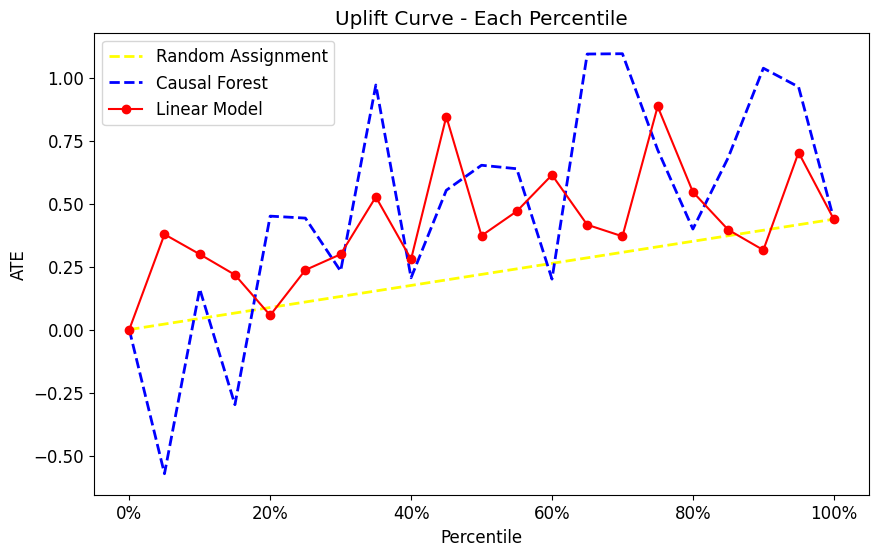

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib 

plt.rcParams.update({'font.size': 12})

fmt = '%.0f%%'
perc = np.linspace(0,100,21)
random = (perc/100) * results_full.params[1]
fig = plt.figure(1, (10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(perc, random, '--', color='yellow', linewidth=2, markersize=2, label='Random Assignment')
ax.plot(perc, df_uplift_curve['cf_bin'].values,'--', color='blue', linewidth=2, markersize=2, label='Causal Forest')
ax.plot(perc, df_uplift_curve['linear_bin'].values, color='red',marker='o', label='Linear Model')

# plt.ylabel('some numbers')

xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.set(xlabel='Percentile', ylabel='ATE', title='Uplift Curve - Each Percentile')
plt.legend()
plt.show()

In [10]:
# AUC unnder curve
print('AUC causal forest', auc(perc, df_uplift_curve['cf_bin'].values), 
      'AUC linear', auc(perc, df_uplift_curve['linear_bin'].values))

AUC causal forest 49.2093824636289 AUC linear 42.24178194041918
